<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/6_4_vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

# **실습 : vanilla GAN 모델 만들기**

## **Import Module**

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import functional as FM
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__
device = 'cuda:0'

In [ ]:
# # gdriver mount to load saved model
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


## **DataSet**

### 라벨있는 샘플 데이타 생성

Label:tensor([1], dtype=torch.int32)


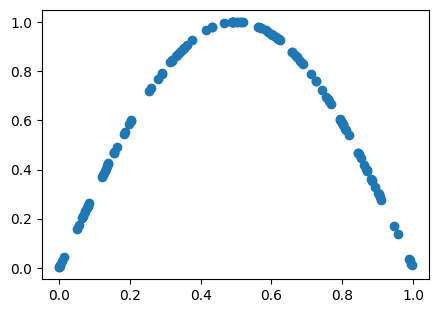

In [ ]:
# generate n real samples with class labels
def real_samples(n):
    X1 = torch.rand(n).view(-1,1) #uniform random
    X2 = torch.sin(X1*torch.pi).view(-1,1)
    X = torch.hstack((X1,X2)) #(n,2)
    y = torch.ones((n,1)) # True
    y = y.type(torch.int)
    return X, y   #((n,2),(n,1))

# plot real samples
# 순서가 random인 sin curve의 일부
data = real_samples(128)
print(f'Label:{data[1][0]}')
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show()

In [ ]:
class RealSampleData(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.X, self.y = real_samples(num_samples)
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## **GAN 모델링**

### 판별기 (discriminator)

In [ ]:
# Discriminator model
class D_model(nn.Module):
    def __init__(self, n_inputs=2):
        super(D_model, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(n_inputs, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
            nn.Sigmoid(), )
    def forward(self, x):
        out = self.discriminator(x)
        return out

D = D_model()
summary(D, input_size=(8, 2))

Layer (type:depth-idx)                   Output Shape              Param #
D_model                                  [8, 1]                    --
├─Sequential: 1-1                        [8, 1]                    --
│    └─Linear: 2-1                       [8, 32]                   96
│    └─ReLU: 2-2                         [8, 32]                   --
│    └─Dropout: 2-3                      [8, 32]                   --
│    └─Linear: 2-4                       [8, 1]                    33
│    └─Sigmoid: 2-5                      [8, 1]                    --
Total params: 129
Trainable params: 129
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
#torch.onnx.export(D, torch.zeros((8, 2)).to(device), 'GAN_discriminator.onnx')

### 생성기 (generator)


In [ ]:
latent_dim = 5
# Generator model
class G_model(nn.Module):
    def __init__(self, n_outputs=2):
        super(G_model, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 16), #Linear(5, 16)
            nn.ReLU(),
            nn.Linear(16, n_outputs),
            nn.Sigmoid(), )
    def forward(self, x):
        out = self.generator(x.to(device))
        return out

G = G_model()
summary(G, input_size=(8, 5))

Layer (type:depth-idx)                   Output Shape              Param #
G_model                                  [8, 2]                    --
├─Sequential: 1-1                        [8, 2]                    --
│    └─Linear: 2-1                       [8, 16]                   96
│    └─ReLU: 2-2                         [8, 16]                   --
│    └─Linear: 2-3                       [8, 2]                    34
│    └─Sigmoid: 2-4                      [8, 2]                    --
Total params: 130
Trainable params: 130
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
#torch.onnx.export(G, torch.zeros((8, 5)).to(device), 'GAN_generator.onnx')

### 잠재공간에서 샘플링(생성기 입력을 위한)


In [ ]:
# generate points in latent space as input for the generator
def latent_points(n):
    x = torch.randn((n, latent_dim))
    return x

latent_points(2)

tensor([[ 0.8174, -2.4315,  0.3990, -0.0157, -1.0538],
        [ 2.3480, -2.1389, -0.3609,  0.0759, -1.9859]])

### 생성기가 가짜 샘플을 생성

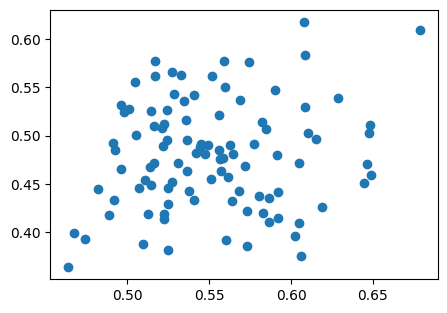

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
    x = latent_points(n)  #(n,5)
    x = generator(x.to(device))#(n,2)<-(n,5)
    x = x.cpu().detach()
    y = torch.zeros(n, 1)  #False
    return x, y 	#(n,2),(n,1)

# plot fake samples
data = generate_fake_samples(G, 100)
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show()

### 판별기 성능 검증 및 진짜와 가짜의 위치 시각화

Epoch:0   Acc_real:0.200000   Acc_fake:0.870000


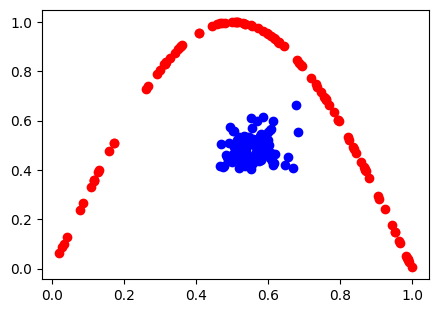

(tensor(0.2000), tensor(0.8700))

In [ ]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, n=100 ):
    # real samples
    x_real, y_real = real_samples(n)
    # evaluate for real acc.
    y_real_pred = discriminator(x_real.to(device))
    acc_real = FM.accuracy(y_real_pred.cpu(), y_real, task='binary', num_classes=2 )

    # fake examples
    x_fake, y_fake = generate_fake_samples(generator, n)
    # evaluate for fake acc.
    y_fake_pred = discriminator(x_fake.to(device))
    acc_fake = FM.accuracy(y_fake_pred.cpu(), y_fake.type(torch.int), task='binary', num_classes=2)

    # summarize discriminator performance
    print("Epoch:%d   Acc_real:%f   Acc_fake:%f" % (epoch, acc_real, acc_fake))
    # scatter plot real and fake data points
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.show()
    return (acc_real,acc_fake)

summarize_performance(0, G, D)

## 생성기와 판별기 학습 및 결과

In [ ]:
batch_size = 512
realDataset = RealSampleData(batch_size)
realLoader = DataLoader(realDataset, batch_size=batch_size, shuffle=True)

In [ ]:
# G = G_model().to(device)
# D = D_model().to(device)

lr = 0.001
loss_function = nn.BCELoss()
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)

Epoch: 0 Loss D.: 0.7005426287651062
Epoch: 0 Loss G.: 0.7138072848320007
Epoch:0   Acc_real:0.250000   Acc_fake:0.860000


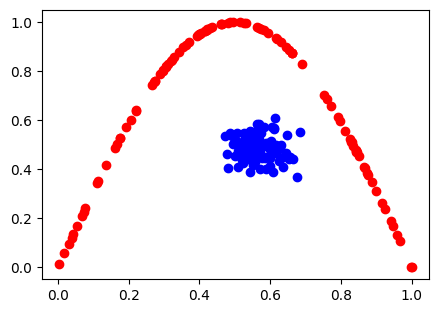

Epoch: 500 Loss D.: 0.66013103723526
Epoch: 500 Loss G.: 0.7613363862037659
Epoch:500   Acc_real:0.350000   Acc_fake:0.940000


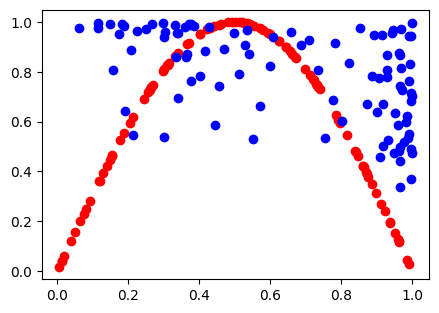

Epoch: 1000 Loss D.: 0.6881577372550964
Epoch: 1000 Loss G.: 0.7043483853340149
Epoch:1000   Acc_real:0.490000   Acc_fake:0.700000


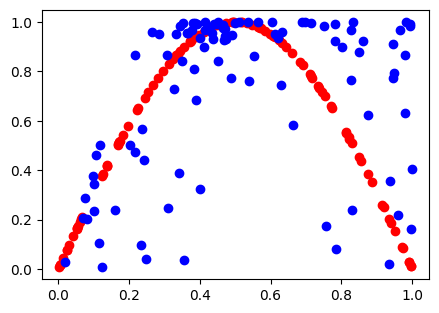

Epoch: 1500 Loss D.: 0.6946809887886047
Epoch: 1500 Loss G.: 0.6974217891693115
Epoch:1500   Acc_real:0.480000   Acc_fake:0.500000


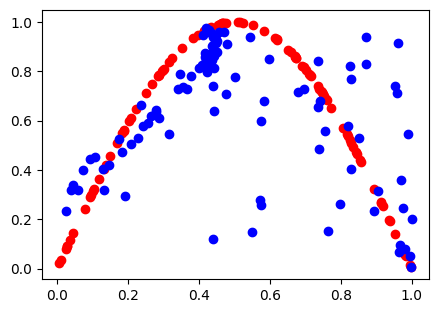

Epoch: 2000 Loss D.: 0.6906333565711975
Epoch: 2000 Loss G.: 0.6976930499076843
Epoch:2000   Acc_real:0.530000   Acc_fake:0.570000


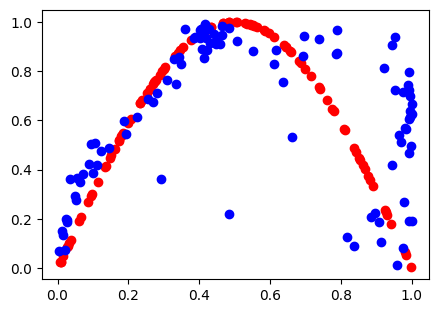

Epoch: 2500 Loss D.: 0.6914874911308289
Epoch: 2500 Loss G.: 0.6955671906471252
Epoch:2500   Acc_real:0.660000   Acc_fake:0.590000


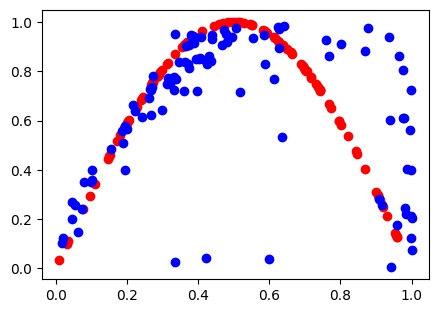

Epoch: 3000 Loss D.: 0.685974657535553
Epoch: 3000 Loss G.: 0.701483428478241
Epoch:3000   Acc_real:0.540000   Acc_fake:0.660000


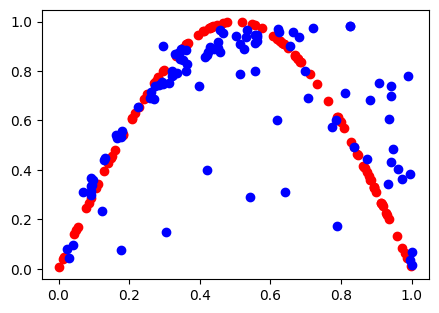

Epoch: 3500 Loss D.: 0.6874328851699829
Epoch: 3500 Loss G.: 0.6985185146331787
Epoch:3500   Acc_real:0.600000   Acc_fake:0.460000


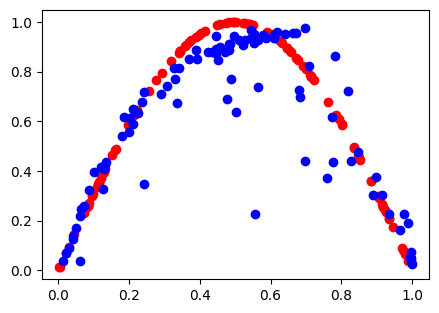

Epoch: 4000 Loss D.: 0.6864793300628662
Epoch: 4000 Loss G.: 0.7004508972167969
Epoch:4000   Acc_real:0.610000   Acc_fake:0.520000


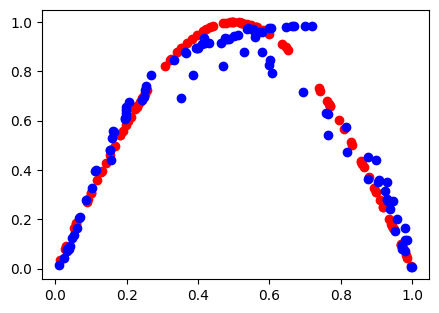

Epoch: 4500 Loss D.: 0.687228798866272
Epoch: 4500 Loss G.: 0.6945656538009644
Epoch:4500   Acc_real:0.660000   Acc_fake:0.450000


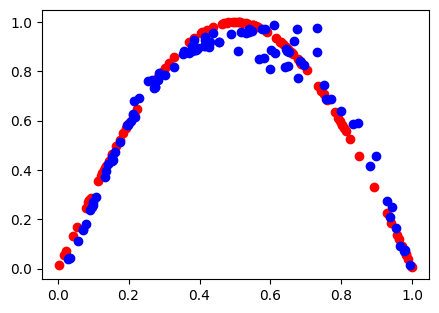

Epoch: 5000 Loss D.: 0.6926774382591248
Epoch: 5000 Loss G.: 0.6902304887771606
Epoch:5000   Acc_real:0.700000   Acc_fake:0.440000


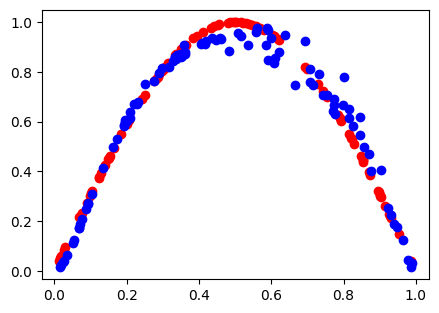

Epoch: 5500 Loss D.: 0.6916184425354004
Epoch: 5500 Loss G.: 0.705534815788269
Epoch:5500   Acc_real:0.740000   Acc_fake:0.520000


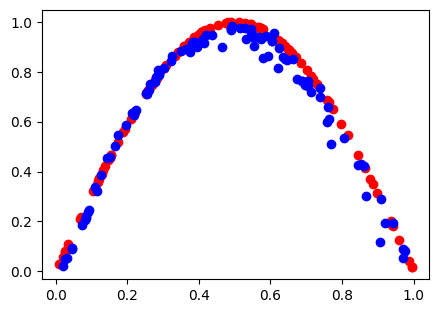

Epoch: 6000 Loss D.: 0.6904721856117249
Epoch: 6000 Loss G.: 0.7026219367980957
Epoch:6000   Acc_real:0.580000   Acc_fake:0.430000


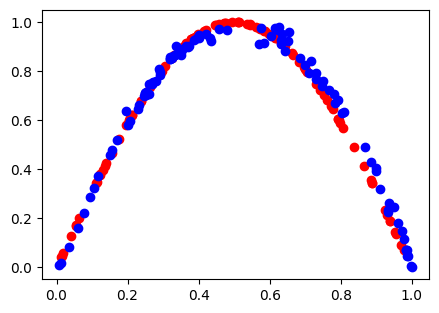

Epoch: 6500 Loss D.: 0.6865667700767517
Epoch: 6500 Loss G.: 0.7039570212364197
Epoch:6500   Acc_real:0.530000   Acc_fake:0.570000


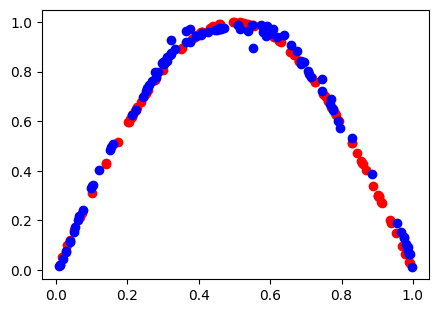

Epoch: 7000 Loss D.: 0.6900652050971985
Epoch: 7000 Loss G.: 0.6911370158195496
Epoch:7000   Acc_real:0.690000   Acc_fake:0.460000


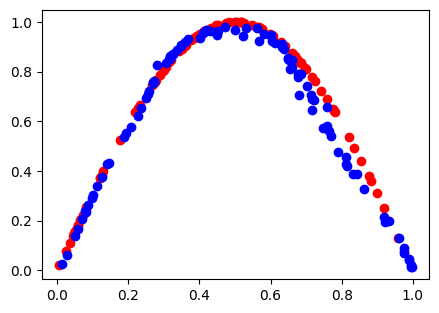

Epoch: 7500 Loss D.: 0.6926653981208801
Epoch: 7500 Loss G.: 0.7028764486312866
Epoch:7500   Acc_real:0.560000   Acc_fake:0.440000


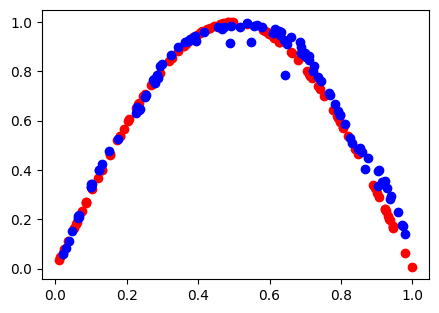

Epoch: 8000 Loss D.: 0.6931146383285522
Epoch: 8000 Loss G.: 0.6874080300331116
Epoch:8000   Acc_real:0.520000   Acc_fake:0.330000


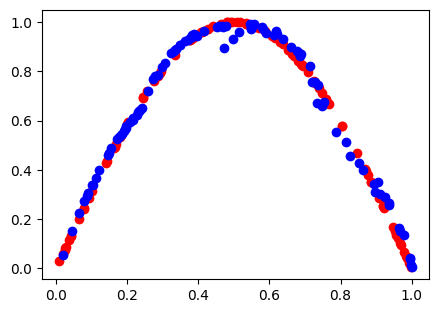

Epoch: 8500 Loss D.: 0.6879695653915405
Epoch: 8500 Loss G.: 0.6973399519920349
Epoch:8500   Acc_real:0.600000   Acc_fake:0.450000


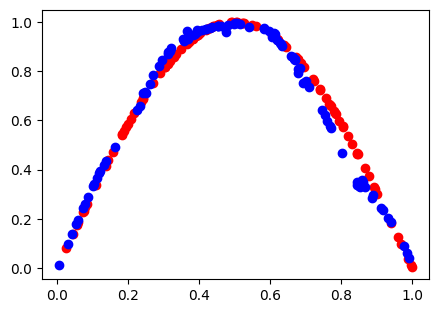

Epoch: 9000 Loss D.: 0.6913914084434509
Epoch: 9000 Loss G.: 0.7040098309516907
Epoch:9000   Acc_real:0.570000   Acc_fake:0.590000


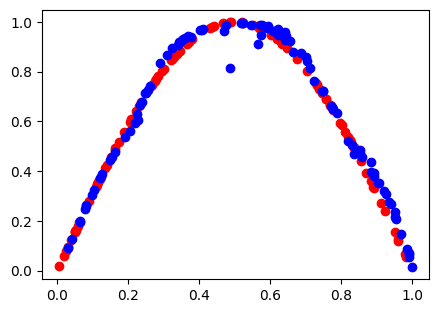

Epoch: 9500 Loss D.: 0.6903222799301147
Epoch: 9500 Loss G.: 0.6927626132965088
Epoch:9500   Acc_real:0.620000   Acc_fake:0.500000


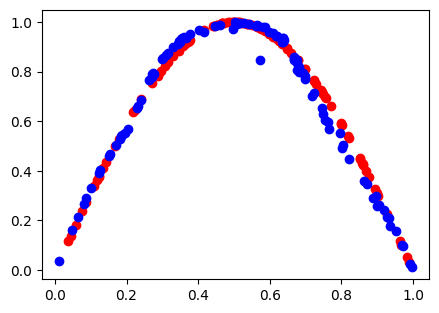

Epoch: 10000 Loss D.: 0.6885926723480225
Epoch: 10000 Loss G.: 0.7162789702415466
Epoch:10000   Acc_real:0.440000   Acc_fake:0.510000


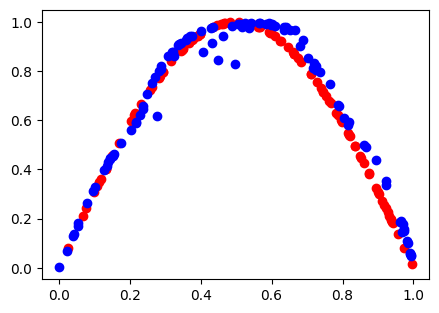

Epoch: 10500 Loss D.: 0.6903406977653503
Epoch: 10500 Loss G.: 0.7111983299255371
Epoch:10500   Acc_real:0.360000   Acc_fake:0.650000


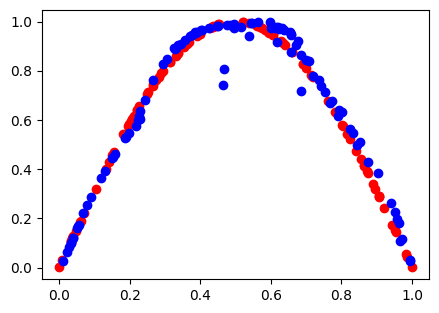

Epoch: 11000 Loss D.: 0.6923237442970276
Epoch: 11000 Loss G.: 0.7113592028617859
Epoch:11000   Acc_real:0.410000   Acc_fake:0.680000


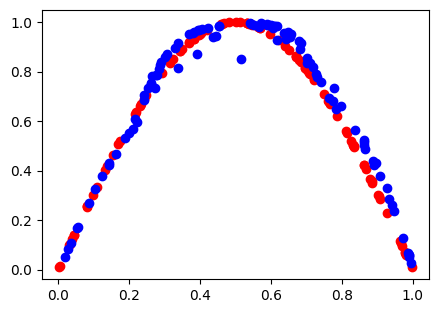

Epoch: 11500 Loss D.: 0.6929641366004944
Epoch: 11500 Loss G.: 0.7078233957290649
Epoch:11500   Acc_real:0.370000   Acc_fake:0.560000


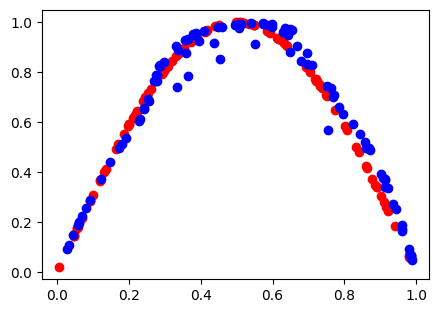

Epoch: 12000 Loss D.: 0.6908995509147644
Epoch: 12000 Loss G.: 0.6922687292098999
Epoch:12000   Acc_real:0.670000   Acc_fake:0.290000


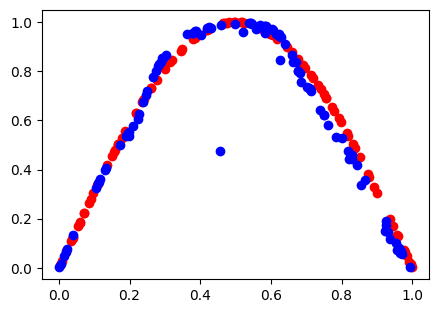

Epoch: 12500 Loss D.: 0.6937118768692017
Epoch: 12500 Loss G.: 0.7162641286849976
Epoch:12500   Acc_real:0.450000   Acc_fake:0.570000


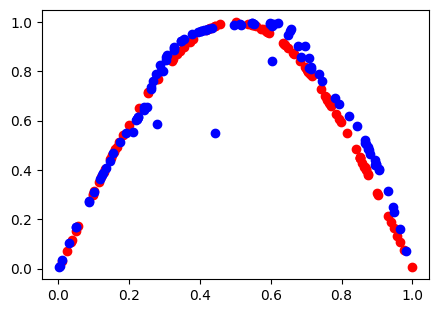

Epoch: 13000 Loss D.: 0.6930941939353943
Epoch: 13000 Loss G.: 0.7141494750976562
Epoch:13000   Acc_real:0.350000   Acc_fake:0.680000


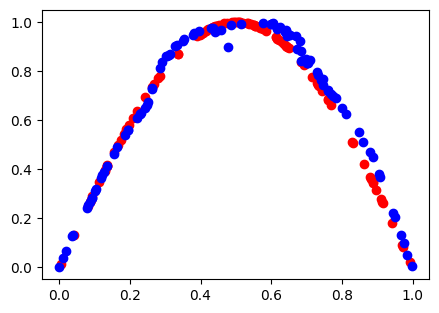

Epoch: 13500 Loss D.: 0.692306399345398
Epoch: 13500 Loss G.: 0.7104811668395996
Epoch:13500   Acc_real:0.380000   Acc_fake:0.630000


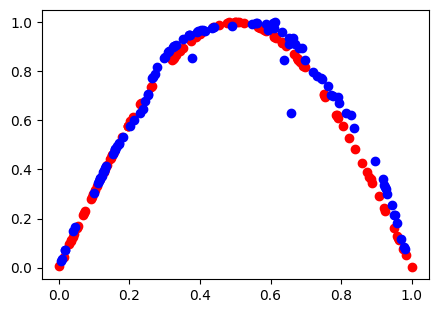

Epoch: 14000 Loss D.: 0.6937572956085205
Epoch: 14000 Loss G.: 0.6906477212905884
Epoch:14000   Acc_real:0.630000   Acc_fake:0.350000


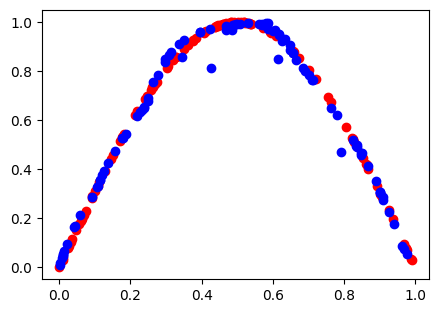

Epoch: 14500 Loss D.: 0.6912351250648499
Epoch: 14500 Loss G.: 0.6894361972808838
Epoch:14500   Acc_real:0.610000   Acc_fake:0.370000


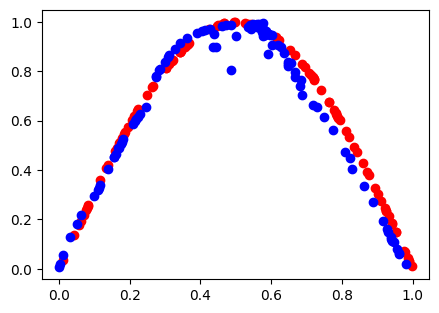

CPU times: user 1min 35s, sys: 7.81 s, total: 1min 43s
Wall time: 1min 37s


In [ ]:
%%time
num_epochs = 15000
for epoch in range(num_epochs):
    for n, (r_samples, r_labels) in enumerate(realLoader):
        ## Data for training the discriminator
        f_samples,f_labels =  generate_fake_samples(G, batch_size)
        all_samples = torch.cat((r_samples, f_samples))
        all_labels = torch.cat((r_labels, f_labels))
        ## Training the discriminator
        D.zero_grad()
        output_d = D(all_samples.to(device))
        loss_d = loss_function(output_d.cpu(), all_labels)
        loss_d.backward()
        optimizer_D.step()

        ## Data for training the generator
        latent_samples = latent_points(batch_size)
        r_labels = r_labels.type(torch.FloatTensor)
        ## Training the generator
        G.zero_grad()
        f_samples = G(latent_samples)
        output_d = D(f_samples)
        loss_g = loss_function(output_d.cpu(), r_labels)
        loss_g.backward()
        optimizer_G.step()

    # Show loss
    if epoch % 500 == 0:
        print(f"Epoch: {epoch} Loss D.: {loss_d}")
        print(f"Epoch: {epoch} Loss G.: {loss_g}")
        summarize_performance(epoch, G, D)

Epoch: 14500 Loss D.: 0.6866230964660645  
Epoch: 14500 Loss G.: 0.707506537437439  
Epoch:0   Acc_real:0.590000   Acc_fake:0.550000  
   
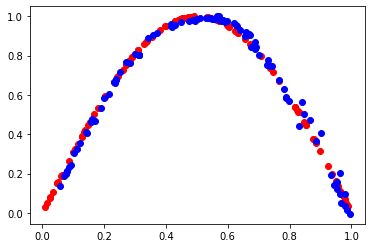

CPU times: user 2min 24s, sys: 3.16 s, total: 2min 27s  
Wall time: 2min 28s

- Model save

In [ ]:
path="./models/" ###
os.makedirs(path, exist_ok=True)

In [ ]:
torch.save(G, path+"vanilla_gan_generator.pt")
torch.save(D, path+"vanilla_gan_discriminator.pt")

- Model load

In [ ]:
discriminator2 = torch.load(path+'vanilla_gan_discriminator.pt')
generator2 = torch.load(path+'vanilla_gan_generator.pt')

In [ ]:
#summary(discriminator2, input_size=(8, 2))

In [ ]:
#summary(generator2, input_size=(8, 5))

Epoch:0   Acc_real:0.660000   Acc_fake:0.380000


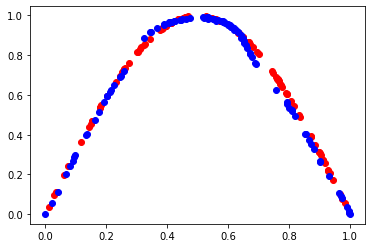

(tensor(0.6600), tensor(0.3800))

In [ ]:
summarize_performance(0,generator2,discriminator2) # Loaded model

Epoch:0   Acc_real:0.670000   Acc_fake:0.600000   
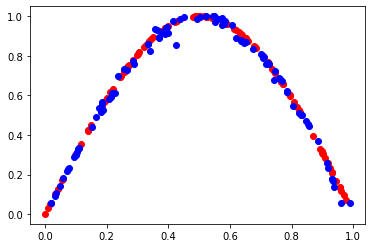

## **실습 과제**

- ####  더 빠른 학습을 위해 모델을 개선해 보자(GAN 모델은 학습이 쉽지 않음)
- #### Latent space vector를 늘리면? latent_dim = ??
- #### Discriminator, Generator 모델을 더 크게 하면??    
- #### epoch = 3000에서 유사한 수준의 학습이 가능할까?? 시도해 보자  





# **실습 : DCGAN with MNIST**

## **Import Module**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import functional as FM
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__
device='cuda:0'

# # gdriver mount to load saved model
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


## **DataSet**

### Load

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, MNIST

class Normalize(object):
    def __call__(self, sample):
        sample = np.array(sample)
        image = (sample - 127.5) / 127.5
        return torch.FloatTensor(image).unsqueeze(dim=0)

# Normalize data to [-1 ~ 1]
mnist_transform = transforms.Compose([
                        Normalize(), ])

# download path 정의
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

### Preprocessing

## **Model**

### Function define for saving model

In [ ]:
save_path="./gdrive/MyDrive/Colab Notebooks/models/"
os.makedirs(save_path, exist_ok=True)

In [ ]:
def save_models(title, epoch):
    torch.save(generator, save_path+"dcgan_generator_{}_{}.pt".format(title, epoch))
    torch.save(discriminator, save_path+"dcgan_discriminator_{}_{}.pt".format(title, epoch))

def load_models(title, epoch):
    gen = torch.load(save_path+"dcgan_generator_{}_{}.pt".format(title, epoch))
    dis = torch.load(save_path+"dcgan_discriminator_{}_{}.pt".format(title, epoch))
    return gen, dis

In [ ]:
train_model = True      # T: training
#train_model = False     # F: loading

### model params

In [ ]:
latent_dim = 100
height = 28
width = 28
channels = 1

### Define generator

In [ ]:
# Generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.Unflatten(1, (128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 5, 2,
                               padding=2, output_padding=1),
            nn.BatchNorm2d(128),  #(128,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2,
                               padding=2, output_padding=1),
            nn.BatchNorm2d(64),   #(64,28,28)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, 1, padding=2),
            nn.BatchNorm2d(32),   #(32,28,28)
            nn.ReLU(),
            nn.Conv2d(32, channels, 5, padding=2),
            nn.Tanh()             #(1,28,28)
        )

    def forward(self, x):
        out = self.generator(x)
        return out

generator = Generator(latent_dim, channels).to(device)
summary(generator, input_size=(8, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [8, 1, 28, 28]            --
├─Sequential: 1-1                        [8, 1, 28, 28]            --
│    └─Linear: 2-1                       [8, 6272]                 633,472
│    └─Unflatten: 2-2                    [8, 128, 7, 7]            --
│    └─BatchNorm2d: 2-3                  [8, 128, 7, 7]            256
│    └─ReLU: 2-4                         [8, 128, 7, 7]            --
│    └─ConvTranspose2d: 2-5              [8, 128, 14, 14]          409,728
│    └─BatchNorm2d: 2-6                  [8, 128, 14, 14]          256
│    └─ReLU: 2-7                         [8, 128, 14, 14]          --
│    └─ConvTranspose2d: 2-8              [8, 64, 28, 28]           204,864
│    └─BatchNorm2d: 2-9                  [8, 64, 28, 28]           128
│    └─ReLU: 2-10                        [8, 64, 28, 28]           --
│    └─ConvTranspose2d: 2-11             [8, 32, 28, 28]           

### Define discriminator

In [ ]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv2d(channels, 32, 5, 2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 5, 2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 5, 2, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 5, 1, padding=2),
            nn.Flatten(),
            nn.Linear(256*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.discriminator(x)
        return out

discriminator = Discriminator(channels).to(device)
summary(discriminator, input_size=(8, channels, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [8, 1]                    --
├─Sequential: 1-1                        [8, 1]                    --
│    └─LeakyReLU: 2-1                    [8, 1, 28, 28]            --
│    └─Conv2d: 2-2                       [8, 32, 14, 14]           832
│    └─LeakyReLU: 2-3                    [8, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [8, 64, 7, 7]             51,264
│    └─LeakyReLU: 2-5                    [8, 64, 7, 7]             --
│    └─Conv2d: 2-6                       [8, 128, 4, 4]            204,928
│    └─LeakyReLU: 2-7                    [8, 128, 4, 4]            --
│    └─Conv2d: 2-8                       [8, 256, 4, 4]            819,456
│    └─Flatten: 2-9                      [8, 4096]                 --
│    └─Linear: 2-10                      [8, 1]                    4,097
│    └─Sigmoid: 2-11                     [8, 1]                    

In [ ]:
#torch.onnx.export(discriminator, torch.zeros((8, channels, height, width)).to(device), '4.4_dcgan_discriminator.onnx')

### Fit function

In [ ]:
batch_size = 64
num_epochs = 10
print_step=100
lr = 0.0001
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True)

In [ ]:
loss_function = nn.BCELoss()

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
def show_images(generated_images, n=4, m=8, figsize=(8, 4)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][0, :, :])#, cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()


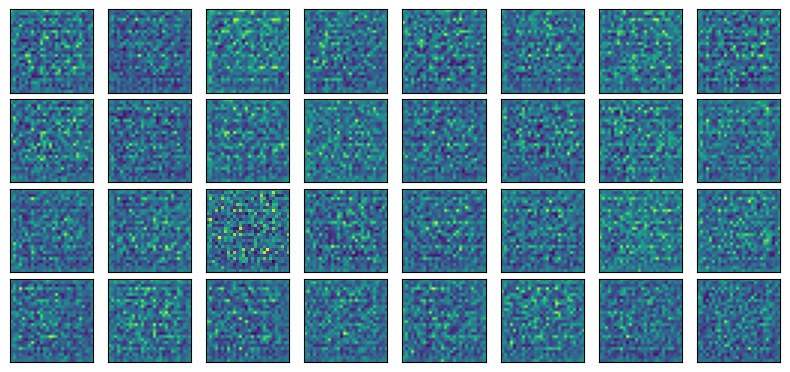

In [ ]:
noise_data = torch.randn((batch_size, latent_dim))
show_images(0.5 * generator(noise_data.to(device)).cpu().detach().numpy() + 0.5) #Generator Af='tanh'

In [ ]:
def train(num_epochs, print_every):
    for epoch in range(num_epochs):
        idx = np.random.randint(0, len(train_dataset), batch_size)
        r_samples = torch.cat([train_dataset[i][0].unsqueeze(dim=0) for i in idx])
        # Data for training the discriminator
        r_labels = torch.ones((batch_size, 1))
        latent_samples = torch.randn((batch_size, latent_dim))
        f_samples = generator(latent_samples.to(device))
        f_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((r_samples.to(device), f_samples))
        all_labels = torch.cat((r_labels, f_labels))
        # Training the discriminator
        discriminator.zero_grad()
        output_d = discriminator(all_samples.to(device))
        loss_d = loss_function(output_d, all_labels.to(device))
        loss_d.backward()
        optimizer_d.step()

        # Data for training the generator
        latent_samples = torch.randn((batch_size, latent_dim))
        # Training the generator
        generator.zero_grad()
        f_samples = generator(latent_samples.to(device))
        output_d = discriminator(f_samples.to(device))
        loss_g = loss_function(output_d, r_labels.to(device))
        loss_g.backward()
        optimizer_g.step()

        # Show loss
        if epoch % print_every == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_d}")
            print(f"Epoch: {epoch} Loss G.: {loss_g}")

### Fit 500

In [ ]:
%%time
if train_model == True:
    history500 = train(500, 10)
    save_models("mnist", 500)
else:
    generator, _, _ = load_models("mnist",500)


>#### Plot 500

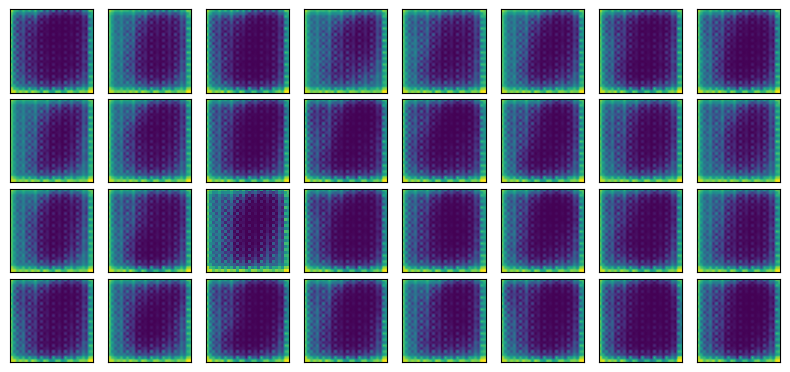

In [ ]:
noise_data = torch.randn((batch_size, latent_dim))
show_images(0.5 * generator(noise_data.to(device)).cpu().detach().numpy() + 0.5) #Generator Af='tanh'

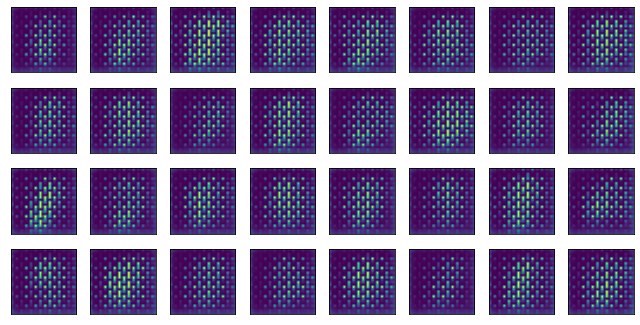

### Fit 4500

In [ ]:
%%time
if train_model == True:
    history500 = train(5000, 100)
    save_models("mnist", 5000)
else:
    generator, _, _ = load_models("mnist", 5000)

Epoch: 0 Loss D.: 0.0224546417593956
Epoch: 0 Loss G.: 4.992191791534424
Epoch: 100 Loss D.: 0.002427357714623213
Epoch: 100 Loss G.: 5.7297210693359375
Epoch: 200 Loss D.: 0.0012122350744903088
Epoch: 200 Loss G.: 6.135471343994141
Epoch: 300 Loss D.: 0.4124531149864197
Epoch: 300 Loss G.: 1.0139631032943726
Epoch: 400 Loss D.: 0.5477743148803711
Epoch: 400 Loss G.: 6.339333534240723
Epoch: 500 Loss D.: 0.08548787236213684
Epoch: 500 Loss G.: 2.4173648357391357
Epoch: 600 Loss D.: 0.03964158892631531
Epoch: 600 Loss G.: 4.218966484069824
Epoch: 700 Loss D.: 0.0048403372056782246
Epoch: 700 Loss G.: 6.018099784851074
Epoch: 800 Loss D.: 0.1672549545764923
Epoch: 800 Loss G.: 2.325650930404663
Epoch: 900 Loss D.: 0.16332527995109558
Epoch: 900 Loss G.: 2.1720237731933594
Epoch: 1000 Loss D.: 0.003184798639267683
Epoch: 1000 Loss G.: 5.943434715270996
Epoch: 1100 Loss D.: 0.0017754121217876673
Epoch: 1100 Loss G.: 7.040976524353027
Epoch: 1200 Loss D.: 0.0003044444601982832
Epoch: 1200 L

CPU times: user 2min 42s, sys: 1.27 s, total: 2min 43s  
Wall time: 2min 45s


>#### Plot 4500

In [ ]:
noise_data = torch.randn((batch_size, latent_dim))
show_images(0.5 * generator(noise_data.to(device)).cpu().detach().numpy() + 0.5) #Generator Af='tanh'

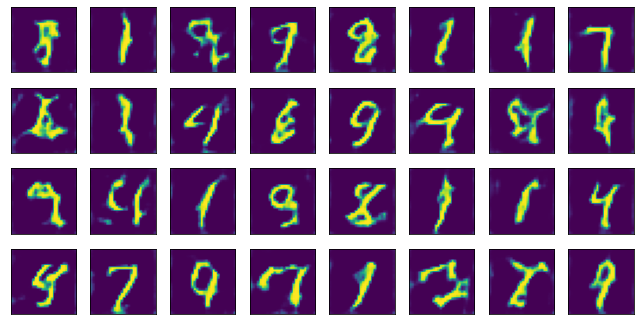

### Fit 15000

In [ ]:
%%time
if train_model == True:
    train(15000, 100)
    save_models("mnist", 20000)
else:
    generator, _, _ = load_models("mnist", 20000)

Epoch: 0 Loss D.: 0.18867173790931702
Epoch: 0 Loss G.: 3.3951516151428223
Epoch: 100 Loss D.: 0.09934473037719727
Epoch: 100 Loss G.: 3.338420867919922
Epoch: 200 Loss D.: 0.08540012687444687
Epoch: 200 Loss G.: 2.9599361419677734
Epoch: 300 Loss D.: 0.15732792019844055
Epoch: 300 Loss G.: 3.4064078330993652
Epoch: 400 Loss D.: 0.14589181542396545
Epoch: 400 Loss G.: 2.85066819190979
Epoch: 500 Loss D.: 0.28950247168540955
Epoch: 500 Loss G.: 2.7802672386169434
Epoch: 600 Loss D.: 0.15949848294258118
Epoch: 600 Loss G.: 3.0890889167785645
Epoch: 700 Loss D.: 0.1239468902349472
Epoch: 700 Loss G.: 3.176581382751465
Epoch: 800 Loss D.: 0.15104490518569946
Epoch: 800 Loss G.: 3.1645867824554443
Epoch: 900 Loss D.: 0.0828867107629776
Epoch: 900 Loss G.: 2.950024127960205
Epoch: 1000 Loss D.: 0.14602576196193695
Epoch: 1000 Loss G.: 2.53828763961792
Epoch: 1100 Loss D.: 0.11324117332696915
Epoch: 1100 Loss G.: 2.070486068725586
Epoch: 1200 Loss D.: 0.12031193822622299
Epoch: 1200 Loss G.: 

Epoch: 14900 Loss G.: 1.7922277450561523  
CPU times: user 8min 11s, sys: 4.07 s, total: 8min 15s  
Wall time: 8min 23s

>#### Plot 15000

In [ ]:
noise_data = torch.randn((batch_size, latent_dim))
show_images(0.5 * generator(noise_data.to(device)).cpu().detach().numpy() + 0.5) #Generator Af='tanh'

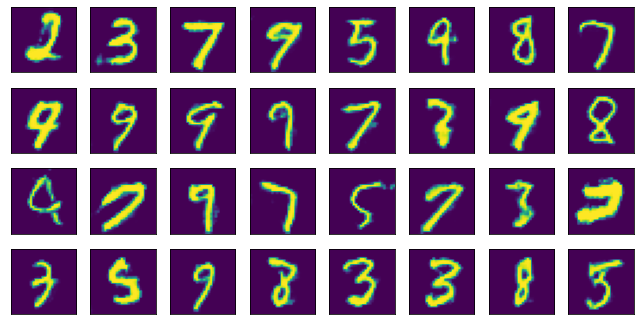

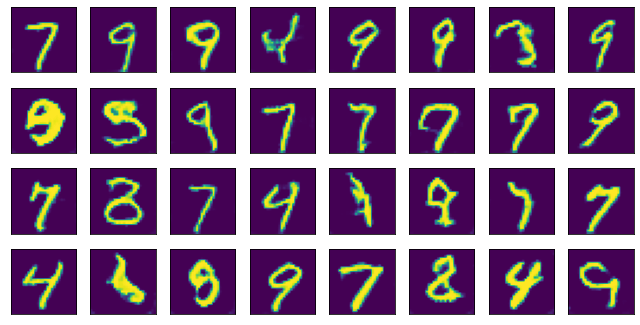

## **DCGAN Model load**

## Load model

### load dc gan mnist and show the result

In [ ]:
latent_dim = 100

In [ ]:
import matplotlib.pyplot as plt

def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][0, :, :])#, cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
generator, _ = load_models("mnist", 20000)

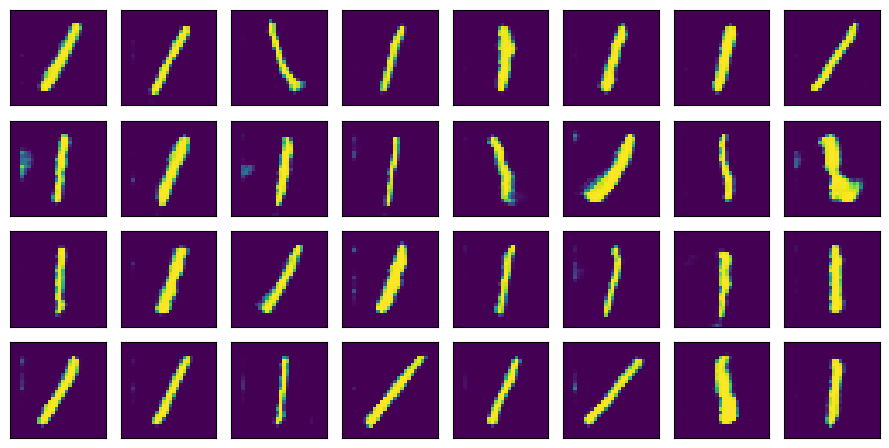

In [ ]:
noise_data = torch.randn((batch_size, latent_dim))
show_images(0.5 * generator(noise_data.to(device)).cpu().detach().numpy() + 0.5)

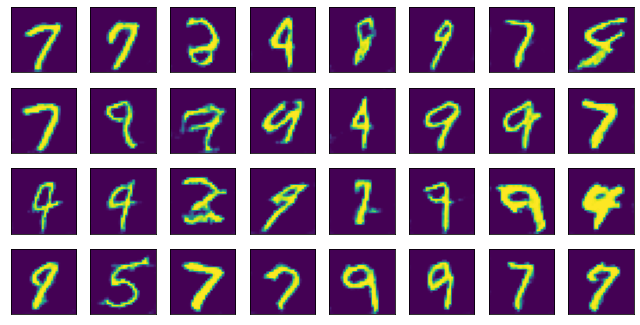